In [1]:
import os
import sys
import casadi as cd
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(os.path.abspath(os.getcwd()))
from Envs.pendulum import Pendulum_Env,Pendulum_Model
from Solvers.OCsolver import ocsolver_v2
from Solvers.Cutter import cutter_v2
from Solvers.MVEsolver import mvesolver
from utils.Correction import Correction_Agent
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
def pendulum_eval():
    # get dynamics, set up step cost and terminal cost
    #0.05
    p_model=Pendulum_Model(10,1,1,0.4,0.02)

    P_matrix=np.array([[0.0,0],
                   [0,0.0]])
    T_matrix=np.array([[25,0],
                   [0,10]])



    dyn_func=p_model.get_dyn_f()
    step_func=p_model.get_step_cost(P_matrix,0.1)
    terminal_func=p_model.get_terminal_cost(T_matrix)

    # set up safety features
    Horizon=40
    Gamma=0.1
    def generate_phi():
            traj=cd.SX.sym('xi',3*Horizon + 2)
            phi=cd.vertcat(cd.DM(-3),traj[3:5])
            return cd.Function('phi',[traj],[phi])

    phi_func=generate_phi() #traj: [x,u,x,u,..,x] phi:[phi0, phi1, phi2]

    lbs=np.array([-6,-6]) #-6
    ubs=np.array([2,2])

    weights_init=(lbs+ubs)/2
    weights_H=np.array([0.6,1])

    #construct environment
    p_env=Pendulum_Env(10,1,1,0.4,0.02)
    p_env.set_init_state(np.array([0,0]))
    #p_env.set_noise(False)
    #construct correction agent
    agent=Correction_Agent('dummy')
    agent.set_state_dim(2)
    agent.set_ctrl_dim(1)
    agent.set_dyn(dyn_func)
    agent.set_step_cost(step_func)
    agent.set_term_cost(terminal_func)
    agent.set_g(phi_func,weights=weights_H,gamma=Gamma)
    #agent.set_threshold(-0.1) #-0.5
    agent.set_threshold(-0.25) #-0.5
    agent.set_p(0.3)
    agent.construct_graph(horizon=Horizon)

    #construct controller
    controller=ocsolver_v2('pendulum control')
    controller.set_state_param(2,[-2*np.pi,-100],[2*np.pi,100])
    controller.set_ctrl_param(1,[-1e10],[1e10])
    controller.set_dyn(dyn_func)
    controller.set_step_cost(step_func)
    controller.set_term_cost(terminal_func)
    #controller.construct_graph(horizon=Horizon)
    controller.set_g(phi_func,gamma=Gamma)
    controller.construct_prob(horizon=Horizon)

    #construct cutter
    hb_calculator=cutter_v2('pendulum cut')
    hb_calculator.from_controller(controller)
    hb_calculator.construct_graph(horizon=Horizon)

    #construct MVESolver
    mve_calc=mvesolver('pendulum_mve',2)

    mve_calc.set_init_constraint(lbs, ubs) #Theta_0

    learned_theta=np.array(weights_init)

    #learning logs
    theta_log=[np.array(weights_init)]
    error_log=[np.linalg.norm(weights_init-weights_H)]

    d_0,C_0=mve_calc.solve()
    v_0=np.log(np.linalg.det(C_0))
    volume_log=[v_0]

    EPISODE=0
    corr_num=0
    termination_flag=False
    while not termination_flag:
        #print('episode',EPISODE)
        # random init
        init_state=np.array([0.,0.])
        init_state[0] += np.random.uniform(0,2*np.pi/3)
        init_state[1] += np.random.uniform(0,3)
        p_env.set_init_state(init_state)
        for i in range(200):
            x=p_env.get_curr_state()
            if np.sqrt(np.sum((x-np.array([np.pi,0]))**2)) <=0.15:
                print('reached desired position')
                break
            #print(i)
            u=controller.control(x,weights=learned_theta)
            agent_output=agent.act(controller.opt_traj)
            if agent_output is None:
                #print('emergency stop')
                break
            elif type(agent_output)==bool:
                pass
            else:
                st=time.time()
                h,b,h_phi,b_phi=hb_calculator.calc_planes(learned_theta,x,controller.opt_traj,np.sign(agent_output))
                #print('cutting plane calculated')
                #print('h',h)
                #print('b',b)
                #print('diff', h.T @ learned_theta - b)
                #print('h_phi',h_phi)
                #print('b_phi',b_phi)

                mve_calc.add_constraint(h,b[0])
                mve_calc.add_constraint(h_phi,b_phi[0])
                learned_theta,C=mve_calc.solve()
                print('learning time', time.time()-st)
                #difference=np.linalg.norm(learned_theta-weights_H)
                difference=learned_theta-weights_H
                vol=np.log(np.linalg.det(C))
                #print('leanred safety param',learned_theta)
                theta_log.append(learned_theta)
                #print('difference', difference)
                error_log.append(np.linalg.norm(difference))
                #print('volume', vol)
                volume_log.append(vol)
                #mve_calc.draw(C,learned_theta,weights_H)
                #if np.max(np.abs(difference))<0.04:
                if np.linalg.norm(difference) < 0.02:
                    print("converged! Final Result: ",learned_theta)
                    termination_flag=True
                    break
                
                corr_num+=1
            p_env.step(u)
        #p_env.show_animation()
        EPISODE+=1

    return theta_log, error_log, volume_log


In [3]:
theta_logs=[]
error_logs=[]
volume_logs=[]

In [4]:
pendulum_eval()

learning time 0.017077207565307617
learning time 0.016235828399658203
learning time 0.017539501190185547
learning time 0.018880605697631836
learning time 0.021339893341064453
learning time 0.023529767990112305
learning time 0.02445530891418457
learning time 0.025427579879760742
learning time 0.05199885368347168


CasADi - 2024-12-05 13:04:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.02855205535888672
learning time 0.0305938720703125
learning time 0.030621051788330078
converged! Final Result:  [0.59296069 0.9892385 ]


([array([-2., -2.]),
  array([-2.3386283 , -0.18797456]),
  array([-2.35388506,  0.76811859]),
  array([-2.22023202,  1.2208358 ]),
  array([-2.65683796,  1.39352895]),
  array([-1.00276518,  1.18853866]),
  array([-0.1695804 ,  1.08319529]),
  array([0.22474976, 1.03371917]),
  array([0.45513869, 0.98805057]),
  array([0.40861941, 1.02998259]),
  array([0.52795636, 1.00376042]),
  array([0.57142963, 0.99389704]),
  array([0.59296069, 0.9892385 ])],
 [3.9698866482558417,
  3.169671882065753,
  2.962972480381265,
  2.8288649793428955,
  3.2805271688902784,
  1.6138162982487079,
  0.7740642409372043,
  0.3767621634536227,
  0.1453533195860914,
  0.19371495493341612,
  0.0721417110625227,
  0.02921492728997262,
  0.012859308901499309],
 [2.772588710982461,
  1.8005671157735743,
  1.1053255472138213,
  0.4469273368492628,
  -0.9534660742508607,
  -1.781338910922622,
  -2.5566451935328836,
  -3.3615731092893886,
  -4.238793924732835,
  -5.027735210901554,
  -5.922639976967011,
  -7.01648083

In [5]:
eval_cnt=0
while eval_cnt<10:
    print('eval num',eval_cnt)
    try:
        tmp_theta_log,tmp_error_log,tmp_volume_log=pendulum_eval()
        if len(tmp_theta_log)<=18:
            theta_logs.append(tmp_theta_log)
            error_logs.append(tmp_error_log)
            volume_logs.append(tmp_volume_log)
            eval_cnt+=1
    except:
        print("error")

eval num 0
learning time 0.015403509140014648
learning time 0.017702102661132812
learning time 0.0182647705078125
learning time 0.019160747528076172
learning time 0.021062850952148438


CasADi - 2024-12-05 13:04:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.022351980209350586
learning time 0.02387094497680664
learning time 0.02530813217163086
learning time 0.02613377571105957


CasADi - 2024-12-05 13:04:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.027916431427001953
learning time 0.029775619506835938
learning time 0.030034780502319336
learning time 0.03211402893066406
learning time 0.03405308723449707


CasADi - 2024-12-05 13:04:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.06114077568054199
learning time 0.03595423698425293
converged! Final Result:  [0.5886278  0.99833573]
eval num 1
learning time 0.013972997665405273
learning time 0.01557302474975586
learning time 0.018131732940673828
learning time 0.019576072692871094
learning time 0.0237882137298584
learning time 0.022808074951171875
learning time 0.024179935455322266
learning time 0.025021791458129883
learning time 0.02622079849243164


CasADi - 2024-12-05 13:04:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.02796792984008789
learning time 0.029245615005493164


CasADi - 2024-12-05 13:04:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.03074026107788086
learning time 0.031391143798828125
converged! Final Result:  [0.59888134 0.98436067]
eval num 2
learning time 0.014077186584472656
learning time 0.015636682510375977
learning time 0.017816543579101562
learning time 0.019367218017578125
learning time 0.020228862762451172
learning time 0.022190332412719727
learning time 0.022708654403686523
learning time 0.025322675704956055
learning time 0.02616119384765625
learning time 0.028307437896728516
reached desired position
learning time 0.029790639877319336
learning time 0.03081822395324707


CasADi - 2024-12-05 13:04:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.032953739166259766
learning time 0.033806800842285156
learning time 0.06092429161071777
converged! Final Result:  [0.59178428 1.00065428]
eval num 3


CasADi - 2024-12-05 13:04:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.016928911209106445
learning time 0.01654195785522461
learning time 0.017767667770385742
learning time 0.018728256225585938
learning time 0.021108388900756836
learning time 0.023153066635131836
learning time 0.023248672485351562
learning time 0.025578022003173828
learning time 0.026721477508544922
learning time 0.02759408950805664
learning time 0.027987241744995117
learning time 0.031161785125732422
reached desired position
learning time 0.03235960006713867
converged! Final Result:  [0.58942915 0.99838864]
eval num 4
learning time 0.014856815338134766
learning time 0.01607203483581543


CasADi - 2024-12-05 13:04:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.01777958869934082


CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.019437074661254883
learning time 0.020542621612548828
learning time 0.02158188819885254
learning time 0.02322983741760254
learning time 0.02560567855834961
learning time 0.0267331600189209
learning time 0.02725839614868164


CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.028867244720458984
learning time 0.029829978942871094
learning time 0.03257608413696289
learning time 0.033612966537475586
learning time 0.03485465049743652
converged! Final Result:  [0.58769442 1.0139313 ]
eval num 5
learning time 0.014381885528564453
learning time 0.015401840209960938
learning time 0.017115116119384766
learning time 0.019181013107299805
learning time 0.021065235137939453
learning time 0.021869182586669922
learning time 0.02431178092956543
reached desired position
learning time 0.025069713592529297
learning time 0.026018857955932617


CasADi - 2024-12-05 13:04:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.02781534194946289
learning time 0.028642892837524414
learning time 0.029636383056640625
learning time 0.03143000602722168


CasADi - 2024-12-05 13:04:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


error
eval num 5
learning time 0.015206098556518555
learning time 0.016094446182250977
learning time 0.0177767276763916
learning time 0.019116640090942383
learning time 0.020244598388671875
learning time 0.046645164489746094


CasADi - 2024-12-05 13:04:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.02364945411682129
learning time 0.024921178817749023
learning time 0.02752852439880371
learning time 0.027722835540771484


CasADi - 2024-12-05 13:04:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.03032994270324707
learning time 0.031198978424072266
learning time 0.03211832046508789


CasADi - 2024-12-05 13:04:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.033121347427368164
converged! Final Result:  [0.59225327 0.99261216]
eval num 6
learning time 0.014926910400390625
learning time 0.01600480079650879
learning time 0.018001794815063477
learning time 0.01927947998046875
learning time 0.02087235450744629
learning time 0.02217864990234375
learning time 0.024238109588623047
learning time 0.025316476821899414
reached desired position
learning time 0.026879549026489258
learning time 0.030423641204833984
learning time 0.029405593872070312


CasADi - 2024-12-05 13:04:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.031168460845947266
learning time 0.03193926811218262


CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.0334172248840332
learning time 0.03457355499267578
converged! Final Result:  [0.60013121 0.98842769]
eval num 7


CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.014869928359985352
learning time 0.016143321990966797
learning time 0.017901182174682617
learning time 0.01947927474975586
learning time 0.02090287208557129
learning time 0.022063016891479492
learning time 0.022783994674682617
learning time 0.02517104148864746
learning time 0.026349306106567383
learning time 0.027566909790039062


CasADi - 2024-12-05 13:04:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.02858710289001465
converged! Final Result:  [0.5893726  0.99094998]
eval num 8
learning time 0.015137195587158203
learning time 0.016010761260986328
learning time 0.01684713363647461
learning time 0.01852560043334961
reached desired position
learning time 0.02023029327392578


CasADi - 2024-12-05 13:04:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.02198934555053711
learning time 0.04818320274353027
learning time 0.024562835693359375
learning time 0.026305198669433594


CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.0274507999420166
learning time 0.028898954391479492
learning time 0.030390262603759766
learning time 0.03115677833557129
learning time 0.03283810615539551
learning time 0.03456830978393555
converged! Final Result:  [0.61065363 0.98391237]
eval num 9
learning time 0.014183282852172852
learning time 0.015676259994506836
learning time 0.017453670501708984
learning time 0.019160747528076172
learning time 0.020105838775634766


CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.021785736083984375
learning time 0.023035049438476562


CasADi - 2024-12-05 13:04:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


learning time 0.024929046630859375
learning time 0.025597810745239258
learning time 0.026767730712890625
reached desired position


CasADi - 2024-12-05 13:04:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-05 13:04:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

learning time 0.030640363693237305
learning time 0.031033039093017578
converged! Final Result:  [0.59045415 0.98646297]


CasADi - 2024-12-05 13:04:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


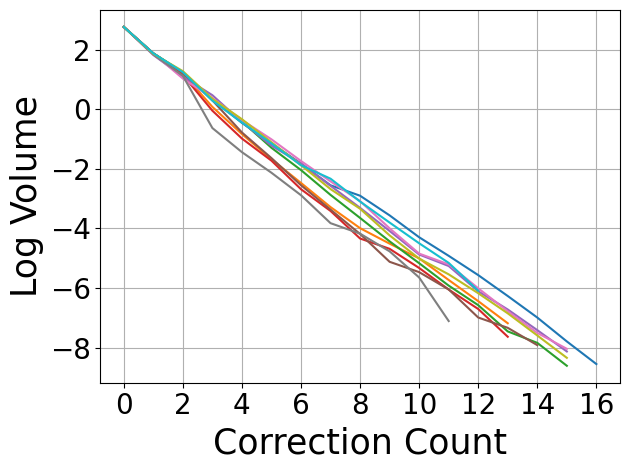

In [27]:
plt.figure()
#plt.title("Logarithm MVE Volume",fontsize=20)
plt.ylabel("Log Volume",fontsize=25)
plt.xlabel("Correction Count",fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i in range(len(volume_logs)):
    plt.plot(np.arange(len(volume_logs[i])),volume_logs[i])
plt.tight_layout()
plt.grid()
plt.savefig('../Data/pendulum/logdet.png')
plt.show()

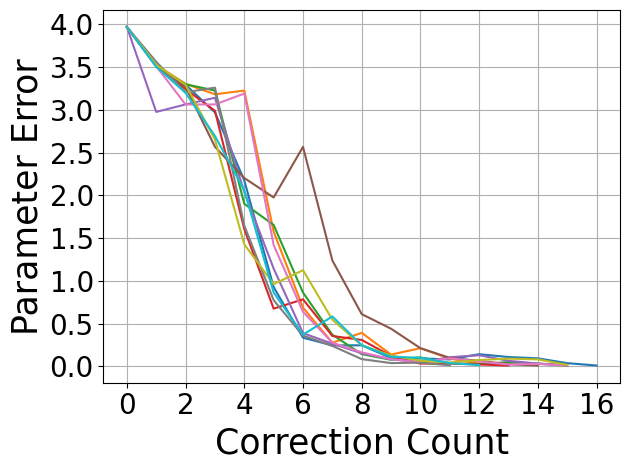

In [26]:
plt.figure()
#plt.title("Parameter Error",fontsize=20)
plt.ylabel("Parameter Error",fontsize=25)
plt.xlabel("Correction Count",fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i in range(len(error_logs)):
    plt.plot(np.arange(len(error_logs[i])),error_logs[i])
plt.tight_layout()
plt.grid()
plt.savefig('../Data/pendulum/loss.png')
plt.show()

In [25]:
def plot_theta_route(ax,theta_log):

    theta_arr=np.array(theta_log[:min(len(theta_log),20)])
    
    for i in range(min(len(theta_log) - 1,19)):
        ax.quiver(theta_arr[i,0], theta_arr[i,1], theta_arr[i+1,0] - theta_arr[i,0], theta_arr[i+1,1] - theta_arr[i,1],
                    angles='xy', scale_units='xy', scale=1,width=0.006, headwidth=3)
        
    ax.scatter(theta_arr[:,0],theta_arr[:,1],color="orange",s=30)




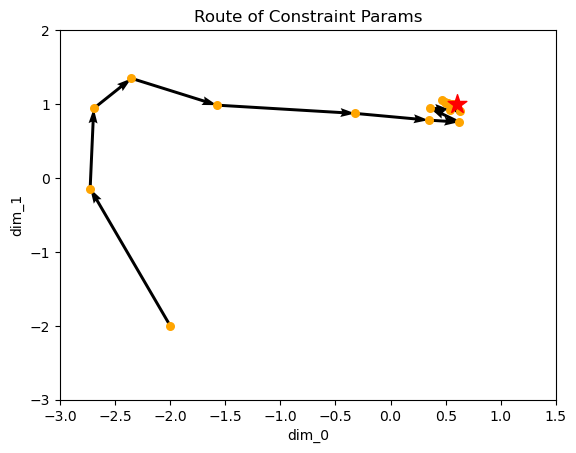

In [18]:
lbs=np.array([-2,-2]) #-6
ubs=np.array([0.5,1])

fig = plt.figure()
# plt.xlabel('dim_0')
# plt.ylabel('dim_1')
# plt.xlim(lbs[0]-1,ubs[0]+1)
# plt.ylim(lbs[1]-1,ubs[1]+1)

ax = fig.add_subplot(111)
ax.set_title("Route of Constraint Params")
ax.set_xlabel('dim_0')
ax.set_ylabel('dim_1')
ax.set_xlim(lbs[0]-1,ubs[0]+1)
ax.set_ylim(lbs[1]-1,ubs[1]+1)

#for i in range(1):
for i in range(1):   
    plot_theta_route(ax,theta_logs[i])
ax.scatter(0.6,1,marker='*',s=200,c="r")
plt.show()

In [19]:
def pendulum_eval_misspec():
    # get dynamics, set up step cost and terminal cost
    #0.05
    p_model=Pendulum_Model(10,1,1,0.4,0.02)

    P_matrix=np.array([[0.0,0],
                   [0,0.0]])
    T_matrix=np.array([[25,0],
                   [0,10]])



    dyn_func=p_model.get_dyn_f()
    step_func=p_model.get_step_cost(P_matrix,0.1)
    terminal_func=p_model.get_terminal_cost(T_matrix)

    # set up safety features
    Horizon=40
    Gamma=0.1
    def generate_phi():
            traj=cd.SX.sym('xi',3*Horizon + 2)
            phi=cd.vertcat(cd.DM(-3),traj[3:5])
            return cd.Function('phi',[traj],[phi])

    phi_func=generate_phi() #traj: [x,u,x,u,..,x] phi:[phi0, phi1, phi2]

    lbs=np.array([-1,-0.8]) #-6
    ubs=np.array([1,0.8])

    weights_init=(lbs+ubs)/2
    weights_H=np.array([0.6,1])

    #construct environment
    p_env=Pendulum_Env(10,1,1,0.4,0.02)
    p_env.set_init_state(np.array([0,0]))
    #p_env.set_noise(False)
    #construct correction agent
    agent=Correction_Agent('dummy')
    agent.set_state_dim(2)
    agent.set_ctrl_dim(1)
    agent.set_dyn(dyn_func)
    agent.set_step_cost(step_func)
    agent.set_term_cost(terminal_func)
    agent.set_g(phi_func,weights=weights_H,gamma=Gamma)
    #agent.set_threshold(-0.1) #-0.5
    agent.set_threshold(-0.25) #-0.5
    agent.set_p(0.3)
    agent.construct_graph(horizon=Horizon)

    #construct controller
    controller=ocsolver_v2('pendulum control')
    controller.set_state_param(2,[-2*np.pi,-100],[2*np.pi,100])
    controller.set_ctrl_param(1,[-1e10],[1e10])
    controller.set_dyn(dyn_func)
    controller.set_step_cost(step_func)
    controller.set_term_cost(terminal_func)
    #controller.construct_graph(horizon=Horizon)
    controller.set_g(phi_func,gamma=Gamma)
    controller.construct_prob(horizon=Horizon)

    #construct cutter
    hb_calculator=cutter_v2('pendulum cut')
    hb_calculator.from_controller(controller)
    hb_calculator.construct_graph(horizon=Horizon)

    #construct MVESolver
    mve_calc=mvesolver('pendulum_mve',2)

    mve_calc.set_init_constraint(lbs, ubs) #Theta_0

    learned_theta=np.array(weights_init)

    #learning logs
    theta_log=[np.array(weights_init)]
    error_log=[np.linalg.norm(weights_init-weights_H)]

    d_0,C_0=mve_calc.solve()
    v_0=np.log(np.linalg.det(C_0))
    volume_log=[v_0]

    EPISODE=0
    corr_num=0
    termination_flag=False
    while not termination_flag:
        #print('episode',EPISODE)
        # random init
        init_state=np.array([0,0])
        init_state[0] += np.random.uniform(0,2*np.pi/3)
        init_state[1] += np.random.uniform(0,3)
        p_env.set_init_state(init_state)
        for i in range(200):
            x=p_env.get_curr_state()
            if np.sqrt(np.sum((x-np.array([np.pi,0]))**2)) <=0.15:
                print('reached desired position')
                break
            #print(i)
            u=controller.control(x,weights=learned_theta)
            agent_output=agent.act(controller.opt_traj)
            if agent_output is None:
                #print('emergency stop')
                break
            elif type(agent_output)==bool:
                pass
            else:
                h,b,h_phi,b_phi=hb_calculator.calc_planes(learned_theta,x,controller.opt_traj,np.sign(agent_output))
                #print('cutting plane calculated')
                #print('h',h)
                #print('b',b)
                #print('diff', h.T @ learned_theta - b)
                #print('h_phi',h_phi)
                #print('b_phi',b_phi)

                mve_calc.add_constraint(h,b[0])
                mve_calc.add_constraint(h_phi,b_phi[0])
                learned_theta,C=mve_calc.solve()
                #difference=np.linalg.norm(learned_theta-weights_H)
                difference=learned_theta-weights_H
                vol=np.log(np.linalg.det(C))
                #print('leanred safety param',learned_theta)
                theta_log.append(learned_theta)
                #print('difference', difference)
                error_log.append(np.linalg.norm(difference))
                #print('volume', vol)
                volume_log.append(vol)
                #mve_calc.draw(C,learned_theta,weights_H)
                #if np.max(np.abs(difference))<0.04:

                corr_num+=1
                
                if corr_num==7:
                    print("stop correcting ",learned_theta)
                    termination_flag=True
                    break
                
                
            p_env.step(u)
        #p_env.show_animation()
        EPISODE+=1

    return theta_log, error_log, volume_log


In [20]:
misspec_theta_log,_,_=pendulum_eval_misspec()

stop correcting  [0.79342705 0.7604461 ]


[0.79342705 0.7604461 ]


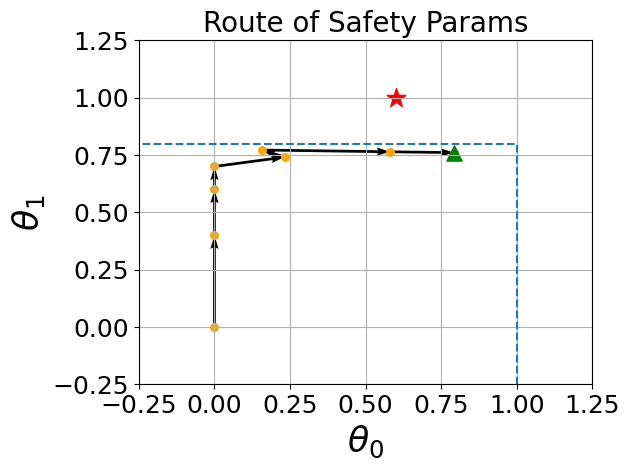

In [21]:

print(misspec_theta_log[-1])
lbs=np.array([-0.25,-0.25]) #-6
ubs=np.array([1.25,1.25])

fig = plt.figure()
# plt.xlabel('dim_0')
# plt.ylabel('dim_1')
# plt.xlim(lbs[0]-1,ubs[0]+1)
# plt.ylim(lbs[1]-1,ubs[1]+1)

ax = fig.add_subplot(111)
ax.set_title("Route of Safety Params",fontsize=20)
# ax.set_xlabel('dim$_0$',fontsize=25)
# ax.set_ylabel('dim$_1$',fontsize=25)
ax.set_xlabel(r'$\theta_0$',fontsize=25)
ax.set_ylabel(r'$\theta_1$',fontsize=25)
ax.set_xlim(lbs[0],ubs[0])
ax.set_ylim(lbs[1],ubs[1])

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
#ax.set_xticklabels([0.0,0.25,0.5,0.75,1.0])
#for i in range(1):
for i in range(1):   
    plot_theta_route(ax,misspec_theta_log)
ax.scatter(0.6,1,marker='*',s=200,c="r")
ax.scatter(misspec_theta_log[-1][0],misspec_theta_log[-1][1],marker='^',s=120,c="g")
ax.plot((-1,1,1),(0.8,0.8,-0.8),linestyle='dashed')
ax.grid()
plt.tight_layout()
plt.show()